## 1. Import Data

In [ ]:
# Import pandas 
import numpy as np 
import pandas as pd

# Import time to measure how long processing takes
import time

# Import sklearn modules for model building
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer

# Import the Snowball stemmer for stemming operations
from nltk.stem.snowball import SnowballStemmer

# Import regex for cleaning and other data processng
import re


import random
from collections import Counter

# Import matplotlib colors for color identification in queries
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt

# Import requests and json for search requests to google
import requests, json

# Import StringIO to handle the attributes file formatting errors on import
from io import StringIO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train=pd.read_csv('./drive/MyDrive/train.csv')
df_test=pd.read_csv('./drive/MyDrive/test.csv')

## 2. Dataset Overview

In [ ]:
# Print the imported tables for initial examination
print('train')
display(df_train.head(),df_train.shape)
print('test')
display(df_test.head(),df_test.shape)
'''
print('product_description')
display(df_pro_desc.head(),df_pro_desc.shape)
print('product_extended_information')
display(df_attr.head(),df_attr.shape)
'''

train


,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


(10158, 6)

test


,id,query,product_title,product_description
0,3,electric griddle,Star-Max 48 in Electric Griddle,NaN
1,6,phillips coffee maker,Philips SENSEO HD7810 WHITE Single Serve Pod C...,NaN
2,9,san francisco 49ers,2013 San Francisco 49ers Clock,A 2013 San Francisco 49ers clock is the ultima...
3,11,aveeno shampoo,AVEENO 10.5FLOZ NRSH SHINE SH,"Water, Ammonium Lauryl Sulfate, Dimethicone, S..."
4,12,flea and tick control for dogs,Merial Frontline Plus Flea and Tick Control fo...,NaN


(22513, 4)

"\nprint('product_description')\ndisplay(df_pro_desc.head(),df_pro_desc.shape)\nprint('product_extended_information')\ndisplay(df_attr.head(),df_attr.shape)\n"

In [ ]:
# TEMP DEBUG CODE

display(df_train.head(100))
print(" ")


,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471
...,...,...,...,...,...,...
95,281,an extremely goofy movie,A Goofy Movie (Full Frame),"DVD, G, 78 minutes, Disney\nNow you can enjoy ...",3,0.894
96,289,gym gloves,"Everlast Wristwrap Glove, Black",NaN,2,0.748
97,290,double stroller,Contours Options Elite Twin Tandem Double Baby...,<table>\n\t<tr>\n\t\t<td>\n\t\t\t\n\n\n\n.styl...,4,0.000
98,295,wine rack,Jumbo Bin 120-Bottle Mahogany Wine Rack,Our Jumbo Bin 120-Bottle Wine Rack is now more...,4,0.000


In [ ]:
# Display summary info of training dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10158 entries, 0 to 10157
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10158 non-null  int64  
 1   query                10158 non-null  object 
 2   product_title        10158 non-null  object 
 3   product_description  7714 non-null   object 
 4   median_relevance     10158 non-null  int64  
 5   relevance_variance   10158 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 476.3+ KB


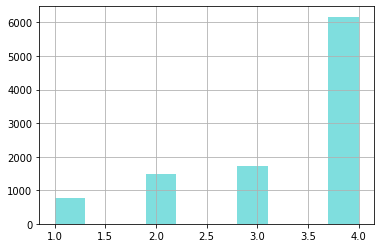

In [ ]:
# Show a histogram of the relevance scores to examine distribution
df_train.median_relevance.hist(color='c', alpha=0.5)
plt.show()

In [ ]:
# Show raw frequencies for unique relevancy score instances
df_train.median_relevance.value_counts()

4    6171
3    1737
2    1476
1     774
Name: median_relevance, dtype: int64

In [ ]:
# Display summary info of testing dataframe
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22513 entries, 0 to 22512
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   22513 non-null  int64 
 1   query                22513 non-null  object
 2   product_title        22513 non-null  object
 3   product_description  17086 non-null  object
dtypes: int64(1), object(3)
memory usage: 703.7+ KB


In [ ]:
# Dislay the testing dataframe to examine the alterations made by spelling correction
df_test.head()

,id,query,product_title,product_description
0,3,electric griddle,Star-Max 48 in Electric Griddle,NaN
1,6,phillips coffee maker,Philips SENSEO HD7810 WHITE Single Serve Pod C...,NaN
2,9,san francisco 49ers,2013 San Francisco 49ers Clock,A 2013 San Francisco 49ers clock is the ultima...
3,11,aveeno shampoo,AVEENO 10.5FLOZ NRSH SHINE SH,"Water, Ammonium Lauryl Sulfate, Dimethicone, S..."
4,12,flea and tick control for dogs,Merial Frontline Plus Flea and Tick Control fo...,NaN


In [ ]:
def drop_nan(df,col_list):
    for i in col_list:
        df = df[df[i].notnull()]
    drop_col = []
    for i in df.columns:
        if i not in col_list:
            drop_col.append(i)
    df = df.drop(drop_col, axis=1)
    return df

In [ ]:
col=['id','query','product_title','product_description','median_relevance','relevance_variance'] 

In [ ]:
df = drop_nan(df_train,col)

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

## 3. Pre-processing

In [ ]:
# Ensure search terms are treated as strings in the training dataset.
# Get the number of training instances (will be used in a later calculation)
df_train["query"]= df_train["query"].astype(str)
num_train = df_train.shape[0]
print(num_train)

5399


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# String cleaning function
# Utilizes regex to:
#      Replace unneeded characters/strings with spaces
#      Collect dimensional indication terms (i.e. "num x num") under a common identifier
#      Collect unit instances under common identifiers to ensure TF-IDF accuracy
#      Convert string representations of numbers to numeric ones
def string_edit(s): 
    if isinstance(s, str):
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s) #Split words with a.A
        s = s.lower()
        s = s.replace("  "," ")
        s = s.replace(",","") #could be number / segment later
        s = s.replace("$"," ")
        s = s.replace("?"," ")
        s = s.replace("-"," ")
        s = s.replace("//","/")
        s = s.replace("..",".")
        s = s.replace(" / "," ")
        s = s.replace(" \\ "," ")
        s = s.replace("."," . ")
        s = re.sub(r"(^\.|/)", r"", s)
        s = re.sub(r"(\.|/)$", r"", s)
        s = re.sub(r"([0-9])([a-z])", r"\1 \2", s)
        s = re.sub(r"([a-z])([0-9])", r"\1 \2", s)
        s = s.replace(" x "," xbi ")
        s = re.sub(r"([a-z])( *)\.( *)([a-z])", r"\1 \4", s)
        s = re.sub(r"([a-z])( *)/( *)([a-z])", r"\1 \4", s)
        s = s.replace("*"," xbi ")
        s = s.replace(" by "," xbi ")
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        
        # Consolidate variations of equivalent unit terms 
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = s.replace("°"," degrees ")
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
        s = s.replace(" v "," volts ")
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        s = s.replace("  "," ")
        s = s.replace(" . "," ")
        
        # Handling numeric instances with common identifiers
        s = re.sub(r"zero\.?", r"0 ", s)
        s = re.sub(r"one\.?", r"1 ", s)
        s = re.sub(r"two\.?", r"2 ", s)
        s = re.sub(r"three\.?", r"3 ", s)
        s = re.sub(r"four\.?", r"4 ", s)
        s = re.sub(r"five\.?", r"5 ", s)
        s = re.sub(r"six\.?", r"6 ", s)
        s = re.sub(r"seven\.?", r"7 ", s)
        s = re.sub(r"eight\.?", r"8 ", s)
        s = re.sub(r"nine\.?", r"9 ", s)
        
        return s
    else:
        # Return a "null" string if the parameter supplied is not a string
        return "null"

In [ ]:
# Defines the stemming function which will call the stemmer on each word
# in the supplied string.
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [ ]:
start_time = time.time()

# Perform stemming function on query, product title, product description.
df_all['query'] = pd.Series(df_all['query'].map(lambda x:str_stemmer(str(x))))
df_all['product_title'] = pd.Series(df_all['product_title'].map(lambda x:str_stemmer(str(x))))
df_all['product_description'] = pd.Series(df_all['product_description'].map(lambda x:str_stemmer(str(x))))


# Operation Time:
print("--- %s seconds ---" % (time.time() - start_time))

--- 618.267942905426 seconds ---


In [ ]:
start_time = time.time()

# Applying the regex string cleaning function to query, product_title, product_description
# See the function definition above for a detailed description of alterations that are made
df_all['query'] = df_all['query'].map(lambda x:string_edit(str(x)))
df_all['product_title'] = df_all['product_title'].map(lambda x:string_edit(str(x)))
df_all['product_description'] = df_all['product_description'].map(lambda x:string_edit(str(x)))


print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Concatinate train and test sets so that pre-processing can be done in one step 
#concat order: train + test 
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True) 

In [ ]:
df_all.head()
print(df_all.shape[0])

7714


In [ ]:

# Split into training and testing sets
# PLEASE NOTE: num_train is defined above in a previous cell. If a file is being loaded in,
# the constant 74067 can be substituted here to achieve the same result.
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]

## 4. calculate TFidf and doing feature reduction

In [ ]:
# Concatinating test and train file so tfidf and feature reduction can be done in 1 step
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [ ]:
# Set the maximum columns to display. Not essential but can help with debugging.
pd.set_option('display.max_columns', 30)

In [ ]:
# Print the head of the collected table for verification
df_all.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,19581,playstation 4,PlayStation 4 500GB Console (PS4),The PlayStation 4 Gaming Console is the best p...,4,0.000
1,13,screen protector samsung,ZAGG InvisibleShield Cell Phone Screen Protect...,Protect your most precious technology with the...,4,0.000
2,20501,shaver panasonic,Panasonic WER9606P Replacement Trimmer Blade,This Panasonic replacement trimmer blade is fo...,2,0.471
3,8643,dean guitar,Dean Exotica Left-Handed Bubinga Acoustic-Elec...,Product Information\n\nDean Exotica Left-Hande...,4,0.471
4,21507,aveeno shampoo,"Aveeno Active Naturals Pure Renewal Shampoo, 1...",Aveeno Active Naturals Shampoo is designed to ...,4,0.000


In [ ]:
# TF-IDF and Truncated SVD initialization (to extract concept using Latent semantics analysis(LSA))
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english') #stop words
svd = TruncatedSVD(n_components=100, random_state = 2019)  #n_components=100 to extract concepts using LSA

In [ ]:
# Creating pipeline to execute TF-IDF and SVD in one step
pipe = Pipeline(steps=[('tfidf', tfidf), ('svd', svd)])

In [ ]:
start_time = time.time()

# Perform fit and transform function of pipeline to convert text(in each feature) into vectors and reducing them 
df_all["product_title"]=pipe.fit_transform(df_all["product_title"])
df_all["query"]=pipe.fit_transform(df_all["query"])
df_all["product_description"]=pipe.fit_transform(df_all["product_description"])

# Operation Time:
print("--- %s seconds ---" % (time.time() - start_time))

--- 19.82649326324463 seconds ---


In [ ]:
# Show the number of missing values that exist in the dataframe
missing = pd.DataFrame(df_all.isnull().sum())
missing[missing[0]>0]

,0


In [ ]:
# Calcuate the number of training items for splitting the full dataframe
num_train=df_train.shape[0]

In [ ]:
# Split the full dataframe into training and testing sets
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]

In [ ]:
# Print the df_train dataframe for verification of features

df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,19581,-0.000249,0.006864,0.049182,4,0.000
1,13,0.000336,0.064768,0.084675,4,0.000
2,20501,-0.000292,0.006362,0.061459,2,0.471
3,8643,0.000693,0.006840,0.045817,4,0.471
4,21507,0.000131,0.024449,0.040045,4,0.000


## 5. Model Building

### Model 1: BERT Model

In [ ]:
!pip install -qq transformers

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
import transformers
from transformers import BertTokenizer,BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
from torch.utils.data import Dataset,DataLoader
class GPReviewDataset(Dataset):

  def __init__(self, reviews1, reviews2, targets, tokenizer, max_len):
    self.reviews1 = reviews1
    self.reviews2 = reviews2
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews1)
  
  def __getitem__(self, item):
    review1 = str(self.reviews1[item])
    review2 = str(self.reviews2[item])
    target = self.targets[item]

    encoding1 = self.tokenizer.encode_plus(
      review1,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    encoding2 = self.tokenizer.encode_plus(
      review2,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text1': review1,
      'review_text2': review2,
      'input_ids1': encoding1['input_ids'].flatten(),
      'attention_mask1': encoding1['attention_mask'].flatten(),
      'input_ids2': encoding2['input_ids'].flatten(),
      'attention_mask2': encoding2['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
#create data loader given the data frame
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews1=df['query'].to_numpy(),
    reviews2=df['product_title'].to_numpy(),
    targets=df.median_relevance.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
#Establish the nerual network based on BERT model
import torch
import torch.nn as nn
import torch.nn.functional as F
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert1 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.bert2 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out1 = nn.Linear(self.bert1.config.hidden_size, n_classes)
    self.out2 = nn.Linear(self.bert2.config.hidden_size, n_classes)
    self.sequential = nn.Sequential(
        nn.Linear(768,256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,16)

    )
  
  def forward(self, input_ids1, attention_mask1 , input_ids2, attention_mask2):
    _, pooled_output = self.bert1(
      input_ids=input_ids1,
      attention_mask=attention_mask1,
      return_dict = False
    )
    output = self.drop(pooled_output)
    out = self.out1(output)
    _, pooled_output2 = self.bert2(
      input_ids=input_ids2,
      attention_mask=attention_mask2,
      return_dict = False
    )
    output2 = self.drop(pooled_output2)
    out2 = self.out2(output2) 
    out = out - out2
    out = self.out1(out).flatten()

    return self.sequential(out)

In [ ]:
#Establish 
class_names = ['0','1','2','3','4']
device = torch.device('cuda:0')
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:

EPOCHS = 20


optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(df_train) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  output = []
  target = []
  for d in data_loader:
   
    input_ids1 = d['input_ids1'].to(device)
    attention_mask1 = d['attention_mask1'].to(device)
    input_ids2 = d['input_ids2'].to(device)
    attention_mask2 = d['attention_mask2'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids1=input_ids1,
      attention_mask1=attention_mask1,
      input_ids2=input_ids2,
      attention_mask2=attention_mask2
    )

    loss = loss_fn(outputs, targets)
    
    correct_predictions += preds.eq(targets.data.view_as(preds)).cpu().sum()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()


  losses = []
  correct_predictions = 0
  
  for d in data_loader:
   
    
    input_ids1 = d['input_ids1'].to(device)
    attention_mask1 = d['attention_mask1'].to(device)
    input_ids2 = d['input_ids2'].to(device)
    attention_mask2 = d['attention_mask2'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids1=input_ids1,
      attention_mask1=attention_mask1,
      input_ids2=input_ids2,
      attention_mask2=attention_mask2
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += preds.eq(targets.data.view_as(preds)).cpu().sum()
    losses.append(loss.item())

    
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 160
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
from collections import defaultdict
import numpy as np

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)



  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(train_data_loader))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,optimizer,device,scheduler,len(val_data_loader))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(range(20),history['train_loss'],'-',linewidth=3,label='training loss error')
plt.plot(range(20),history['val_loss'],'-',linewidth=3,label='validation loss error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()


### Model 2: Gradient Boosting regressor

In [ ]:
# Define the MSE function to be used for calculating RMSE
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.1
    return fmean_squared_error_

In [ ]:
# Define the RMSE scorer for internal model evaluation
RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

In [ ]:
# Create a copy of the dataset for testing purposes. Allows for verification of operations.
df_test_1 = df_test.copy()
df_train_1 = df_train.copy()


# Collect the IDs for the test and split off the relevance feature as this is the "target" of the model
id_test = df_test_1['id']
y_train = df_train_1['median_relevance'].values
y_test = df_test_1['median_relevance'].values
# Remove those features (id and relevance) from the dataframes so the model can be properly calculated
X_train = df_train_1.drop(['id','product_description','median_relevance','relevance_variance'],axis=1).values
X_test = df_test_1.drop(['id','product_description','median_relevance','relevance_variance'],axis=1).values

In [ ]:
X_test

array([[-6.19596934e-05,  4.57110584e-02],
       [ 9.59523527e-04,  4.64011969e-03],
       [ 5.01945497e-04,  1.83346474e-02],
       ...,
       [-6.12412943e-06,  1.06767942e-02],
       [-1.06852361e-04,  4.60442688e-03],
       [-4.31903157e-05,  6.63926091e-03]])

In [ ]:
# Intialize a Gradient Boost Regressor for determining ideal model parameters
gbr = GradientBoostingRegressor()

In [ ]:
# Define the parameters that should be tested for final model generation
param_grid = {
            'n_estimators' : np.array([int(e) for e in np.linspace(30, 40, 11)]),
            'max_depth': np.array([int(e) for e in np.linspace(2, 10, 5)])
                                      }

In [ ]:
# Initialize a Grid Search Cross Validation object with above regressor and the parameters to test.
# RMSE is used as the scoring metric for ranking parameters
gs = GridSearchCV(estimator = gbr, param_grid = param_grid, cv = 3, scoring=RMSE)

In [ ]:
# Fit the Grid Search model to the training set (performs 3 cross validations)
%time _ = gs.fit(X_train, y_train)

CPU times: user 25.6 s, sys: 36 ms, total: 25.7 s
Wall time: 25.6 s


In [ ]:
# Display the best parameters found by the above Grid Search fit
gs.best_params_, gs.best_score_

({'max_depth': 8, 'n_estimators': 39}, -0.9834593676554357)

In [ ]:

# Run the prediction on the testing set
y_pred = np.round(gs.predict(X_test))

from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score,mean_squared_error as mse
print(mse(y_test,y_pred, squared=False))

0.5099180521760506


In [ ]:
# Initialize a new Gradient Boost Regressor with the parameters found from the above calculation
gbr1 = GradientBoostingRegressor(max_depth=8,n_estimators=39)

# Fit this new regressor to the training data again
gbr1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=36,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Run the prediction on the testing set
y_pred = np.round(gbr1.predict(X_test))

from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score,mean_squared_error as mse
print(mse(y_test,y_pred, squared=False))
print(cohen_kappa_score(y_test,y_pred,weights='sample'))


0.4836679276019202
0.6837646169773446
